This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 3.5 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

In [ ]:
train = train.drop(columns=['latitude', 'longitude'])
test = test.drop(columns=['latitude', 'longitude'])

In [ ]:
train_ = train.copy()
test_ = test.copy()
train_[['id', 'name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'] + ['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_country', 'near_url', 'near_phone', 'near_categories', 'near_target']] = train_[['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_country', 'near_url', 'near_phone', 'near_categories', 'near_target'] + ['id', 'name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest']]
test_[['id', 'name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'] + ['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_country', 'near_url', 'near_phone', 'near_categories', 'near_target']] = test_[['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_country', 'near_url', 'near_phone', 'near_categories', 'near_target'] + ['id', 'name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest']]

In [ ]:
train = pd.concat([train, train_])
test = pd.concat([test, test_])
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

In [ ]:
gc.collect()

263

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,address,city,state,zip,country,url,phone,categories,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets",...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,cap del carrer,la massana,nan,nan,ad,nan,nan,restaurants,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira","el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,+376753191,ski areas,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,nan,la massana,nan,ad400,ad,nan,737350,sporting goods shops,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


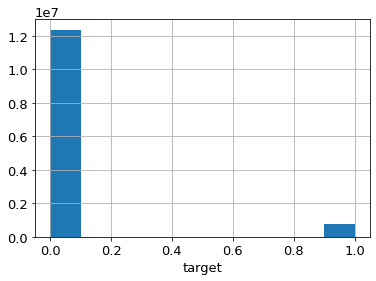

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8992020370291575


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 57.3 MB/s 
     |████████████████████████████████| 103 kB 58.8 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,address,city,state,zip,country,url,phone,categories,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,address,city,state,zip,country,url,phone,categories,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",nan,nan,nan,nan,id,nan,nan,stadiums,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['country_pair'] = train[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['country_pair'] = test[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,address,city,state,zip,country,url,phone,categories,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,country_pair
12,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places",...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(ad, ad)"
13,E_1514d74b987ae1,ahotels piolets park & spa,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets",...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(ad, ad)"
14,E_206f06060f193d,la borda xica,cap del carrer,la massana,nan,nan,ad,nan,nan,restaurants,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(ad, ad)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira","el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,+376753191,ski areas,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(ad, ad)"
16,E_4a34a5012e88c3,pic negre 11,nan,la massana,nan,ad400,ad,nan,737350,sporting goods shops,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(ad, ad)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "country_pair"]]
test = test[features + ["id", "near_id", "country_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13131590 entries, 0 to 13131589
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["country_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "country_pair"], train.loc[val_ind, "country_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,94.23%,5.77%
development set - fold 0,94.12%,5.88%
validation set - fold 0,94.44%,5.56%
development set - fold 1,94.10%,5.90%
validation set - fold 1,94.47%,5.53%
development set - fold 2,94.46%,5.54%
validation set - fold 2,93.77%,6.23%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0624568
[100]	valid_0's binary_logloss: 0.0615554

== fold 1 ==
[50]	valid_0's binary_logloss: 0.0820524
[100]	valid_0's binary_logloss: 0.0808128

== fold 2 ==
[50]	valid_0's binary_logloss: 0.101609
[100]	valid_0's binary_logloss: 0.100292
[150]	valid_0's binary_logloss: 0.0995692

CV-accuracy: 0.9702449589120586


In [ ]:
train["pred"] = oof[:, -1]

In [ ]:
# train["id_pair"] = train[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
# test["id_pair"] = test[['id', 'near_id']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
# train["pred"] = train["id_pair"].map(dict(train.groupby("id_pair")["pred"].mean()))

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 210 kB 72.2 MB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 
     |████████████████████████████████| 146 kB 34.6 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 112 kB 19.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5113fb5027f188ff6af9b672d18a5c2aa6f627ca1aa60223da155d2504b9caaf
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 15:44:28,262] A new study created in memory with name: no-name-9f995372-4610-44a5-a39a-fc7f38785f3a
[I 2022-05-13 15:44:59,326] Trial 0 finished with value: 0.7533928330855294 and parameters: {'threshold': 0.11510857482984738}. Best is trial 0 with value: 0.7533928330855294.


CV: 0.753393, precision: 0.853243, recall: 0.877606


[I 2022-05-13 15:45:26,489] Trial 1 finished with value: 0.8020034128249129 and parameters: {'threshold': 0.5356900703595464}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.802003, precision: 0.962333, recall: 0.833855


[I 2022-05-13 15:45:48,926] Trial 2 finished with value: 0.7969978255107285 and parameters: {'threshold': 0.6627331722099633}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.796998, precision: 0.976171, recall: 0.816978


[I 2022-05-13 15:46:06,512] Trial 3 finished with value: 0.7659044337247116 and parameters: {'threshold': 0.8676065840874337}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.765904, precision: 0.992890, recall: 0.771828


[I 2022-05-13 15:46:26,400] Trial 4 finished with value: 0.7923528058825371 and parameters: {'threshold': 0.7201726809532802}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.792353, precision: 0.981716, recall: 0.807776


[I 2022-05-13 15:46:42,925] Trial 5 finished with value: 0.7543481999747976 and parameters: {'threshold': 0.8984379382902675}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.754348, precision: 0.995008, recall: 0.758489


[I 2022-05-13 15:47:02,784] Trial 6 finished with value: 0.787872770076857 and parameters: {'threshold': 0.7593869504144075}. Best is trial 1 with value: 0.8020034128249129.


CV: 0.787873, precision: 0.985023, recall: 0.800509


[I 2022-05-13 15:47:25,368] Trial 7 finished with value: 0.8022816178894521 and parameters: {'threshold': 0.5105318685656254}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.802282, precision: 0.959233, recall: 0.836829


[I 2022-05-13 15:47:52,291] Trial 8 finished with value: 0.7741103613532186 and parameters: {'threshold': 0.17224718872548206}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.774110, precision: 0.885614, recall: 0.871320


[I 2022-05-13 15:48:11,555] Trial 9 finished with value: 0.7918336198829453 and parameters: {'threshold': 0.725723233819523}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.791834, precision: 0.982223, recall: 0.806837


[I 2022-05-13 15:48:36,868] Trial 10 finished with value: 0.7966545185330697 and parameters: {'threshold': 0.3218781440756804}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.796655, precision: 0.929938, recall: 0.856652


[I 2022-05-13 15:48:59,697] Trial 11 finished with value: 0.8021040970658161 and parameters: {'threshold': 0.4685151939488775}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.802104, precision: 0.953642, recall: 0.841513


[I 2022-05-13 15:49:23,054] Trial 12 finished with value: 0.8006834956011717 and parameters: {'threshold': 0.3986260389876072}. Best is trial 7 with value: 0.8022816178894521.


CV: 0.800683, precision: 0.943486, recall: 0.848957


[I 2022-05-13 15:49:45,090] Trial 13 finished with value: 0.8022944194020885 and parameters: {'threshold': 0.49422083703291236}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802294, precision: 0.957120, recall: 0.838669


[I 2022-05-13 15:50:09,771] Trial 14 finished with value: 0.7923463441771823 and parameters: {'threshold': 0.2753679634258164}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.792346, precision: 0.919625, recall: 0.861184


[I 2022-05-13 15:50:31,852] Trial 15 finished with value: 0.8012970084368765 and parameters: {'threshold': 0.5682817171716043}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801297, precision: 0.966124, recall: 0.829860


[I 2022-05-13 15:50:52,023] Trial 16 finished with value: 0.8001483794733567 and parameters: {'threshold': 0.6014275170098757}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.800148, precision: 0.969777, recall: 0.825551


[I 2022-05-13 15:51:16,064] Trial 17 finished with value: 0.8017958179867386 and parameters: {'threshold': 0.4446314228662219}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801796, precision: 0.950313, recall: 0.844111
CV: 0.623889, precision: 0.682780, recall: 0.891782


[I 2022-05-13 15:51:52,108] Trial 18 finished with value: 0.6238887199830301 and parameters: {'threshold': 0.021133514165501188}. Best is trial 13 with value: 0.8022944194020885.
[I 2022-05-13 15:52:15,727] Trial 19 finished with value: 0.7998572987979038 and parameters: {'threshold': 0.3771638565612927}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.799857, precision: 0.940008, recall: 0.851163


[I 2022-05-13 15:52:25,607] Trial 20 finished with value: 0.6653196945038139 and parameters: {'threshold': 0.988536200361984}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.665320, precision: 0.999875, recall: 0.665422


[I 2022-05-13 15:52:48,706] Trial 21 finished with value: 0.8022321498708086 and parameters: {'threshold': 0.481462504326219}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802232, precision: 0.955443, recall: 0.840060


[I 2022-05-13 15:53:14,032] Trial 22 finished with value: 0.7932383090912201 and parameters: {'threshold': 0.2831221311022709}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.793238, precision: 0.921555, recall: 0.860424


[I 2022-05-13 15:53:36,271] Trial 23 finished with value: 0.8022765093066537 and parameters: {'threshold': 0.5045245935598763}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802277, precision: 0.958455, recall: 0.837500


[I 2022-05-13 15:53:57,391] Trial 24 finished with value: 0.7991210262197858 and parameters: {'threshold': 0.626187775683655}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.799121, precision: 0.972436, recall: 0.822264


[I 2022-05-13 15:54:19,478] Trial 25 finished with value: 0.8022032457993492 and parameters: {'threshold': 0.5232810838719003}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802203, precision: 0.960837, recall: 0.835364


[I 2022-05-13 15:54:44,010] Trial 26 finished with value: 0.7997210420909093 and parameters: {'threshold': 0.37386078490637187}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.799721, precision: 0.939439, recall: 0.851520


[I 2022-05-13 15:55:09,364] Trial 27 finished with value: 0.7872916094368638 and parameters: {'threshold': 0.23705710379361422}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.787292, precision: 0.909200, recall: 0.864869


[I 2022-05-13 15:55:29,460] Trial 28 finished with value: 0.7976859411898995 and parameters: {'threshold': 0.6522826857123528}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.797686, precision: 0.975115, recall: 0.818550


[I 2022-05-13 15:55:55,410] Trial 29 finished with value: 0.8013224633641103 and parameters: {'threshold': 0.4182417173982085}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801322, precision: 0.946501, recall: 0.846971


[I 2022-05-13 15:56:13,646] Trial 30 finished with value: 0.7767490290026277 and parameters: {'threshold': 0.8257981852125098}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.776749, precision: 0.989944, recall: 0.785186


[I 2022-05-13 15:56:35,969] Trial 31 finished with value: 0.802202316127221 and parameters: {'threshold': 0.5237383787632894}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802202, precision: 0.960899, recall: 0.835308


[I 2022-05-13 15:56:58,392] Trial 32 finished with value: 0.8021639766136298 and parameters: {'threshold': 0.47424859820652404}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802164, precision: 0.954435, recall: 0.840875


[I 2022-05-13 15:57:19,901] Trial 33 finished with value: 0.8013404496033678 and parameters: {'threshold': 0.5665410456625962}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801340, precision: 0.965917, recall: 0.830085


[I 2022-05-13 15:57:42,019] Trial 34 finished with value: 0.802240911792572 and parameters: {'threshold': 0.48257243713956866}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802241, precision: 0.955588, recall: 0.839948


[I 2022-05-13 15:58:04,068] Trial 35 finished with value: 0.8012093350184488 and parameters: {'threshold': 0.5720252158470449}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801209, precision: 0.966576, recall: 0.829379


[I 2022-05-13 15:58:28,327] Trial 36 finished with value: 0.7975095833261174 and parameters: {'threshold': 0.3345677341288728}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.797510, precision: 0.932436, recall: 0.855382


[I 2022-05-13 15:58:48,484] Trial 37 finished with value: 0.7958340066369424 and parameters: {'threshold': 0.6797288384448922}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.795834, precision: 0.977903, recall: 0.814375


[I 2022-05-13 15:59:10,512] Trial 38 finished with value: 0.8022048139133253 and parameters: {'threshold': 0.523383636597609}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802205, precision: 0.960853, recall: 0.835351


[I 2022-05-13 15:59:28,593] Trial 39 finished with value: 0.7856362893394899 and parameters: {'threshold': 0.7756038711036723}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.785636, precision: 0.986294, recall: 0.797206


[I 2022-05-13 15:59:55,880] Trial 40 finished with value: 0.7778990627417685 and parameters: {'threshold': 0.18752710243922172}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.777899, precision: 0.891964, recall: 0.869744


[I 2022-05-13 16:00:18,455] Trial 41 finished with value: 0.8021848836964064 and parameters: {'threshold': 0.4759159826534335}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.802185, precision: 0.954665, recall: 0.840696


[I 2022-05-13 16:00:41,937] Trial 42 finished with value: 0.801694278351049 and parameters: {'threshold': 0.43892086108030126}. Best is trial 13 with value: 0.8022944194020885.


CV: 0.801694, precision: 0.949490, recall: 0.844728


[I 2022-05-13 16:01:04,257] Trial 43 finished with value: 0.8022947395204206 and parameters: {'threshold': 0.4961829255206241}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802295, precision: 0.957384, recall: 0.838443


[I 2022-05-13 16:01:24,101] Trial 44 finished with value: 0.7944150514215679 and parameters: {'threshold': 0.6976019948529459}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.794415, precision: 0.979663, recall: 0.811542


[I 2022-05-13 16:01:44,955] Trial 45 finished with value: 0.7992561871637842 and parameters: {'threshold': 0.6233968624315471}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.799256, precision: 0.972142, recall: 0.822647


[I 2022-05-13 16:02:08,727] Trial 46 finished with value: 0.7994027487957637 and parameters: {'threshold': 0.3677445735752154}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.799403, precision: 0.938367, recall: 0.852135


[I 2022-05-13 16:02:30,265] Trial 47 finished with value: 0.8015252763651647 and parameters: {'threshold': 0.5589871819597975}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.801525, precision: 0.965075, recall: 0.830993


[I 2022-05-13 16:02:52,321] Trial 48 finished with value: 0.8022697371655058 and parameters: {'threshold': 0.5053623412034536}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802270, precision: 0.958561, recall: 0.837401


[I 2022-05-13 16:03:16,601] Trial 49 finished with value: 0.8013280594398566 and parameters: {'threshold': 0.4188740917544802}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.801328, precision: 0.946585, recall: 0.846902


[I 2022-05-13 16:03:38,936] Trial 50 finished with value: 0.8022781875265871 and parameters: {'threshold': 0.510124089789521}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802278, precision: 0.959177, recall: 0.836874


[I 2022-05-13 16:03:58,867] Trial 51 finished with value: 0.7999903678082763 and parameters: {'threshold': 0.6056644641814674}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.799990, precision: 0.970243, recall: 0.825000


[I 2022-05-13 16:04:21,508] Trial 52 finished with value: 0.8022778784109937 and parameters: {'threshold': 0.5184425649810046}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802278, precision: 0.960249, recall: 0.835943


[I 2022-05-13 16:04:43,072] Trial 53 finished with value: 0.8017906029653069 and parameters: {'threshold': 0.5493408927268346}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.801791, precision: 0.963976, recall: 0.832214


[I 2022-05-13 16:05:07,311] Trial 54 finished with value: 0.7981358776600159 and parameters: {'threshold': 0.34421014774153413}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.798136, precision: 0.934240, recall: 0.854447


[I 2022-05-13 16:05:30,701] Trial 55 finished with value: 0.8016954838466978 and parameters: {'threshold': 0.43906522004654047}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.801695, precision: 0.949511, recall: 0.844712


[I 2022-05-13 16:05:52,353] Trial 56 finished with value: 0.800515454046333 and parameters: {'threshold': 0.5923550908038973}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.800515, precision: 0.968829, recall: 0.826747


[I 2022-05-13 16:06:15,431] Trial 57 finished with value: 0.8009815234413765 and parameters: {'threshold': 0.40640032779761}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.800982, precision: 0.944697, recall: 0.848188


[I 2022-05-13 16:06:37,288] Trial 58 finished with value: 0.8021492346217781 and parameters: {'threshold': 0.5265275414151861}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802149, precision: 0.961227, recall: 0.834967


[I 2022-05-13 16:06:57,124] Trial 59 finished with value: 0.790083439122225 and parameters: {'threshold': 0.7412977877853059}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.790083, precision: 0.983530, recall: 0.803992


[I 2022-05-13 16:07:17,781] Trial 60 finished with value: 0.7976070259283905 and parameters: {'threshold': 0.6533266734205619}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.797607, precision: 0.975213, recall: 0.818392


[I 2022-05-13 16:07:40,238] Trial 61 finished with value: 0.8022785269503349 and parameters: {'threshold': 0.4976458685673757}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.802279, precision: 0.957564, recall: 0.838271


[I 2022-05-13 16:08:03,116] Trial 62 finished with value: 0.8018342109990995 and parameters: {'threshold': 0.4462898143971138}. Best is trial 43 with value: 0.8022947395204206.


CV: 0.801834, precision: 0.950551, recall: 0.843942


[I 2022-05-13 16:08:26,408] Trial 63 finished with value: 0.8022948357599412 and parameters: {'threshold': 0.4941993628005944}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802295, precision: 0.957115, recall: 0.838674


[I 2022-05-13 16:08:50,990] Trial 64 finished with value: 0.795430766686237 and parameters: {'threshold': 0.30648059235136876}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.795431, precision: 0.926758, recall: 0.858160


[I 2022-05-13 16:09:12,829] Trial 65 finished with value: 0.8022894747745035 and parameters: {'threshold': 0.5026550253779121}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802289, precision: 0.958212, recall: 0.837720


[I 2022-05-13 16:09:36,476] Trial 66 finished with value: 0.8021129677403624 and parameters: {'threshold': 0.46649366993723085}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802113, precision: 0.953378, recall: 0.841754


[I 2022-05-13 16:09:57,539] Trial 67 finished with value: 0.8009249858922064 and parameters: {'threshold': 0.5807342331611158}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.800925, precision: 0.967578, recall: 0.828242


[I 2022-05-13 16:10:21,992] Trial 68 finished with value: 0.8001876743226841 and parameters: {'threshold': 0.3852431061120475}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.800188, precision: 0.941337, recall: 0.850337


[I 2022-05-13 16:10:44,933] Trial 69 finished with value: 0.8022728199908072 and parameters: {'threshold': 0.4972322505359252}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802273, precision: 0.957509, recall: 0.838314


[I 2022-05-13 16:11:05,831] Trial 70 finished with value: 0.7989320635986745 and parameters: {'threshold': 0.6307885328576136}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.798932, precision: 0.972935, recall: 0.821648


[I 2022-05-13 16:11:27,785] Trial 71 finished with value: 0.8022787127992352 and parameters: {'threshold': 0.5105898268714721}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802279, precision: 0.959237, recall: 0.836822


[I 2022-05-13 16:11:49,346] Trial 72 finished with value: 0.8019382950713352 and parameters: {'threshold': 0.5426026050060888}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.801938, precision: 0.963188, recall: 0.833050


[I 2022-05-13 16:12:12,062] Trial 73 finished with value: 0.8019693685410177 and parameters: {'threshold': 0.4571641240787052}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.801969, precision: 0.952043, recall: 0.842764


[I 2022-05-13 16:12:34,671] Trial 74 finished with value: 0.8022868058139796 and parameters: {'threshold': 0.4890500342677472}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802287, precision: 0.956466, recall: 0.839231


[I 2022-05-13 16:12:57,974] Trial 75 finished with value: 0.8013228163965811 and parameters: {'threshold': 0.41880552484374983}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.801323, precision: 0.946573, recall: 0.846908


[I 2022-05-13 16:13:20,267] Trial 76 finished with value: 0.8022605281412671 and parameters: {'threshold': 0.4862628719702909}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802261, precision: 0.956077, recall: 0.839540


[I 2022-05-13 16:13:43,497] Trial 77 finished with value: 0.8019460766460419 and parameters: {'threshold': 0.5420814410213501}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.801946, precision: 0.963123, recall: 0.833113


[I 2022-05-13 16:14:16,075] Trial 78 finished with value: 0.690970956173171 and parameters: {'threshold': 0.04476458760660135}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.690971, precision: 0.767293, recall: 0.887181


[I 2022-05-13 16:14:36,908] Trial 79 finished with value: 0.8001789343485569 and parameters: {'threshold': 0.600795454257229}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.800179, precision: 0.969711, recall: 0.825636


[I 2022-05-13 16:15:00,573] Trial 80 finished with value: 0.7992737481558636 and parameters: {'threshold': 0.3644196405423975}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.799274, precision: 0.937834, recall: 0.852475


[I 2022-05-13 16:15:22,393] Trial 81 finished with value: 0.8022802438388197 and parameters: {'threshold': 0.4993647429220591}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.802280, precision: 0.957790, recall: 0.838077


[I 2022-05-13 16:15:44,968] Trial 82 finished with value: 0.8019682903432345 and parameters: {'threshold': 0.45682947922794703}. Best is trial 63 with value: 0.8022948357599412.


CV: 0.801968, precision: 0.951997, recall: 0.842802


[I 2022-05-13 16:16:06,912] Trial 83 finished with value: 0.8023100984039598 and parameters: {'threshold': 0.4926633878645558}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802310, precision: 0.956932, recall: 0.838852


[I 2022-05-13 16:16:28,346] Trial 84 finished with value: 0.8015042298603 and parameters: {'threshold': 0.5597856252813613}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801504, precision: 0.965163, recall: 0.830894


[I 2022-05-13 16:16:51,098] Trial 85 finished with value: 0.8014975596196473 and parameters: {'threshold': 0.42772342876702174}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801498, precision: 0.947868, recall: 0.845946


[I 2022-05-13 16:17:13,437] Trial 86 finished with value: 0.8022054553461385 and parameters: {'threshold': 0.47670140307625297}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802205, precision: 0.954785, recall: 0.840611


[I 2022-05-13 16:17:39,827] Trial 87 finished with value: 0.8007405805030905 and parameters: {'threshold': 0.40040362161009846}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.800741, precision: 0.943743, recall: 0.848780


[I 2022-05-13 16:18:01,647] Trial 88 finished with value: 0.8019672485134265 and parameters: {'threshold': 0.5384907652320847}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801967, precision: 0.962666, recall: 0.833522


[I 2022-05-13 16:18:23,867] Trial 89 finished with value: 0.8022847735417905 and parameters: {'threshold': 0.500143216861146}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802285, precision: 0.957891, recall: 0.837993


[I 2022-05-13 16:18:45,104] Trial 90 finished with value: 0.8011381914275068 and parameters: {'threshold': 0.5735583815744014}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801138, precision: 0.966748, recall: 0.829169


[I 2022-05-13 16:19:07,266] Trial 91 finished with value: 0.8022861691778074 and parameters: {'threshold': 0.48909910746100016}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802286, precision: 0.956473, recall: 0.839224


[I 2022-05-13 16:19:29,913] Trial 92 finished with value: 0.8018958134428119 and parameters: {'threshold': 0.45156941524282174}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801896, precision: 0.951262, recall: 0.843376


[I 2022-05-13 16:19:52,145] Trial 93 finished with value: 0.8022580323456089 and parameters: {'threshold': 0.4847782729424695}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802258, precision: 0.955888, recall: 0.839703


[I 2022-05-13 16:20:13,701] Trial 94 finished with value: 0.8021954141742028 and parameters: {'threshold': 0.5241244385637491}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802195, precision: 0.960946, recall: 0.835262


[I 2022-05-13 16:20:37,010] Trial 95 finished with value: 0.8003899459532783 and parameters: {'threshold': 0.39007837558351494}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.800390, precision: 0.942122, recall: 0.849849


[I 2022-05-13 16:21:00,364] Trial 96 finished with value: 0.8015767940308348 and parameters: {'threshold': 0.43125696684263193}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801577, precision: 0.948402, recall: 0.845562


[I 2022-05-13 16:21:22,639] Trial 97 finished with value: 0.8023013980465391 and parameters: {'threshold': 0.49368316912077304}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.802301, precision: 0.957055, recall: 0.838737


[I 2022-05-13 16:21:38,724] Trial 98 finished with value: 0.7308179236772379 and parameters: {'threshold': 0.938817779192706}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.730818, precision: 0.997553, recall: 0.732820


[I 2022-05-13 16:21:59,935] Trial 99 finished with value: 0.8017676882737407 and parameters: {'threshold': 0.5503422536795771}. Best is trial 83 with value: 0.8023100984039598.


CV: 0.801768, precision: 0.964095, recall: 0.832086


In [ ]:
threshold = study.best_params['threshold']
threshold

0.4926633878645558

In [ ]:
study.best_value

0.8023100984039598

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.802310, precision: 0.956932, recall: 0.838852


# Check Feature Importances

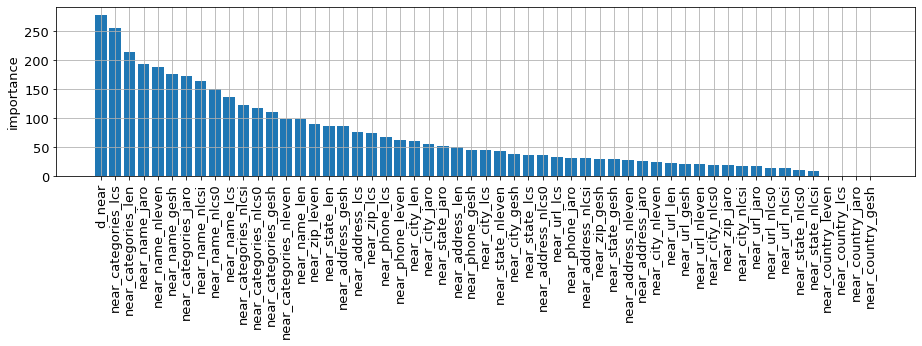

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 16:22:23,144] A new study created in memory with name: no-name-7fafb517-7184-4aaf-a38c-e6c29b260aad


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:25:35,854] Trial 0 finished with value: 0.5522573766305156 and parameters: {'threshold': 0.013074190563263532}. Best is trial 0 with value: 0.5522573766305156.


CV: 0.552257, precision: 0.597115, recall: 0.894604


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:27:19,175] Trial 1 finished with value: 0.8029275202152122 and parameters: {'threshold': 0.5149858374854686}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.802928, precision: 0.954495, recall: 0.841633


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:29:09,036] Trial 2 finished with value: 0.7913916714470262 and parameters: {'threshold': 0.29644563284560743}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.791392, precision: 0.917070, recall: 0.862496


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:30:33,192] Trial 3 finished with value: 0.8000707942233498 and parameters: {'threshold': 0.6642234387602036}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.800071, precision: 0.972429, recall: 0.823301


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:31:56,653] Trial 4 finished with value: 0.7939525675988304 and parameters: {'threshold': 0.7492338998736899}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.793953, precision: 0.981230, recall: 0.809842


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:33:50,684] Trial 5 finished with value: 0.7890342268921917 and parameters: {'threshold': 0.27731431370396964}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.789034, precision: 0.912251, recall: 0.864244


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:35:46,849] Trial 6 finished with value: 0.8001305280132777 and parameters: {'threshold': 0.414140113335833}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.800131, precision: 0.939609, recall: 0.851817


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.707444, precision: 0.788940, recall: 0.885570


[I 2022-05-13 16:38:05,682] Trial 7 finished with value: 0.7074435013987941 and parameters: {'threshold': 0.06455168924013999}. Best is trial 1 with value: 0.8029275202152122.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:39:31,025] Trial 8 finished with value: 0.794640371962084 and parameters: {'threshold': 0.7418777613967442}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.794640, precision: 0.980535, recall: 0.811130


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:41:08,427] Trial 9 finished with value: 0.8025912518899408 and parameters: {'threshold': 0.4956161462667771}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.802591, precision: 0.951783, recall: 0.843655


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:42:05,304] Trial 10 finished with value: 0.7059974174611673 and parameters: {'threshold': 0.9691866633211517}. Best is trial 1 with value: 0.8029275202152122.


CV: 0.705997, precision: 0.998952, recall: 0.706848


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:43:35,251] Trial 11 finished with value: 0.8030679894324904 and parameters: {'threshold': 0.5395781018649674}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.803068, precision: 0.957712, recall: 0.838948


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:45:17,118] Trial 12 finished with value: 0.80233133675597 and parameters: {'threshold': 0.5958324945491669}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.802331, precision: 0.964651, recall: 0.832209


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:46:27,496] Trial 13 finished with value: 0.756904733752396 and parameters: {'threshold': 0.9104087124786606}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.756905, precision: 0.994779, recall: 0.761227


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:48:14,260] Trial 14 finished with value: 0.7985167728378083 and parameters: {'threshold': 0.3821818739096817}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.798517, precision: 0.934290, recall: 0.854806


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:49:44,868] Trial 15 finished with value: 0.8028781642627296 and parameters: {'threshold': 0.5618167557413947}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.802878, precision: 0.960519, recall: 0.836332


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:51:44,366] Trial 16 finished with value: 0.7738738376961427 and parameters: {'threshold': 0.19380964485702368}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.773874, precision: 0.884947, recall: 0.871726


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:53:01,717] Trial 17 finished with value: 0.7832657930827693 and parameters: {'threshold': 0.8258794150524971}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.783266, precision: 0.987920, recall: 0.793427


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:54:51,658] Trial 18 finished with value: 0.8013498857745921 and parameters: {'threshold': 0.4492040198809812}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.801350, precision: 0.945010, recall: 0.848329


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:56:20,574] Trial 19 finished with value: 0.8014595729460198 and parameters: {'threshold': 0.6295768950091349}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.801460, precision: 0.968537, recall: 0.828011


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:58:14,164] Trial 20 finished with value: 0.7948294343133792 and parameters: {'threshold': 0.3311618713269525}. Best is trial 11 with value: 0.8030679894324904.


CV: 0.794829, precision: 0.924659, recall: 0.859438


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 16:59:43,644] Trial 21 finished with value: 0.8030721869849715 and parameters: {'threshold': 0.5465250485050303}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.803072, precision: 0.958642, recall: 0.838153


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:01:22,228] Trial 22 finished with value: 0.8030570643767341 and parameters: {'threshold': 0.5386778920441607}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.803057, precision: 0.957595, recall: 0.839038


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:02:50,232] Trial 23 finished with value: 0.7930139208794725 and parameters: {'threshold': 0.7576576125008169}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.793014, precision: 0.982033, recall: 0.808224


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:04:12,817] Trial 24 finished with value: 0.7993424535733367 and parameters: {'threshold': 0.6793734411390351}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.799342, precision: 0.974124, recall: 0.821149


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:05:46,375] Trial 25 finished with value: 0.8029659535972826 and parameters: {'threshold': 0.5215639931179661}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.802966, precision: 0.955375, recall: 0.840915


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:07:48,183] Trial 26 finished with value: 0.7645389396799822 and parameters: {'threshold': 0.16007597850537125}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.764539, precision: 0.869980, recall: 0.874975


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.801943, precision: 0.947963, recall: 0.846336


[I 2022-05-13 17:09:31,006] Trial 27 finished with value: 0.8019426862766242 and parameters: {'threshold': 0.4692998574990321}. Best is trial 21 with value: 0.8030721869849715.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:11:03,280] Trial 28 finished with value: 0.8028513578971155 and parameters: {'threshold': 0.5643328880512142}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.802851, precision: 0.960837, recall: 0.836035


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.796731, precision: 0.929349, recall: 0.857301


[I 2022-05-13 17:12:52,038] Trial 29 finished with value: 0.7967305218569782 and parameters: {'threshold': 0.3547782115852054}. Best is trial 21 with value: 0.8030721869849715.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:14:15,036] Trial 30 finished with value: 0.7992700508844877 and parameters: {'threshold': 0.6802716694838401}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.799270, precision: 0.974213, recall: 0.821005


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:15:53,211] Trial 31 finished with value: 0.8029379341786063 and parameters: {'threshold': 0.5153732525378075}. Best is trial 21 with value: 0.8030721869849715.


CV: 0.802938, precision: 0.954550, recall: 0.841597


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:17:35,060] Trial 32 finished with value: 0.8030876656092255 and parameters: {'threshold': 0.5415611008719206}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.803088, precision: 0.957985, recall: 0.838742


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:19:04,966] Trial 33 finished with value: 0.8024449502359547 and parameters: {'threshold': 0.5919184759145407}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.802445, precision: 0.964215, recall: 0.832701


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:20:47,353] Trial 34 finished with value: 0.80093295790417 and parameters: {'threshold': 0.4358540195444539}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.800933, precision: 0.942991, recall: 0.849677


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:22:11,358] Trial 35 finished with value: 0.8015062494685568 and parameters: {'threshold': 0.6281077158098111}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.801506, precision: 0.968388, recall: 0.828184


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:23:43,240] Trial 36 finished with value: 0.8030598725878877 and parameters: {'threshold': 0.5380219608918283}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.803060, precision: 0.957514, recall: 0.839116


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:25:36,528] Trial 37 finished with value: 0.7851997291184712 and parameters: {'threshold': 0.25132971384875524}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.785200, precision: 0.904940, recall: 0.866525


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:27:22,352] Trial 38 finished with value: 0.7997415214119538 and parameters: {'threshold': 0.40565037951698346}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.799742, precision: 0.938241, recall: 0.852609


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:28:46,405] Trial 39 finished with value: 0.7967661495154861 and parameters: {'threshold': 0.718493992824993}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.796766, precision: 0.978276, recall: 0.815136


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:30:06,241] Trial 40 finished with value: 0.7838876565494906 and parameters: {'threshold': 0.8227249098587324}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.783888, precision: 0.987687, recall: 0.794252


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:31:41,772] Trial 41 finished with value: 0.803083091368927 and parameters: {'threshold': 0.5414108102545631}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.803083, precision: 0.957964, recall: 0.838756


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.801828, precision: 0.947303, recall: 0.846802


[I 2022-05-13 17:33:24,993] Trial 42 finished with value: 0.8018276641435246 and parameters: {'threshold': 0.4646761980302328}. Best is trial 32 with value: 0.8030876656092255.


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.801583, precision: 0.967991, recall: 0.828594


[I 2022-05-13 17:34:48,967] Trial 43 finished with value: 0.8015834468070718 and parameters: {'threshold': 0.6249127763793161}. Best is trial 32 with value: 0.8030876656092255.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:36:22,899] Trial 44 finished with value: 0.802868413637582 and parameters: {'threshold': 0.5120917373089303}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.802868, precision: 0.954103, recall: 0.841915


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:37:50,833] Trial 45 finished with value: 0.8024917584410011 and parameters: {'threshold': 0.5905790455292176}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.802492, precision: 0.964065, recall: 0.832875


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:39:28,497] Trial 46 finished with value: 0.8023189267356803 and parameters: {'threshold': 0.4835509307589212}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.802319, precision: 0.950081, recall: 0.844864


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:41:14,025] Trial 47 finished with value: 0.7990015622603087 and parameters: {'threshold': 0.39042866513602037}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.799002, precision: 0.935724, recall: 0.854051


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:42:44,750] Trial 48 finished with value: 0.8028797668296463 and parameters: {'threshold': 0.5617452962734778}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.802880, precision: 0.960512, recall: 0.836339


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:44:06,969] Trial 49 finished with value: 0.8000741470385438 and parameters: {'threshold': 0.6636052239608601}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.800074, precision: 0.972343, recall: 0.823379


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:45:30,768] Trial 50 finished with value: 0.7895428763006261 and parameters: {'threshold': 0.7864281237272064}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.789543, precision: 0.984642, recall: 0.802531


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:47:01,248] Trial 51 finished with value: 0.8030513748928144 and parameters: {'threshold': 0.5382091219302358}. Best is trial 32 with value: 0.8030876656092255.


CV: 0.803051, precision: 0.957530, recall: 0.839092


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:48:30,370] Trial 52 finished with value: 0.8030945871526566 and parameters: {'threshold': 0.5445460886022684}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803095, precision: 0.958387, recall: 0.838402


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.800727, precision: 0.942055, recall: 0.850285


[I 2022-05-13 17:50:12,920] Trial 53 finished with value: 0.8007270066997444 and parameters: {'threshold': 0.42983993977944684}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:51:38,022] Trial 54 finished with value: 0.8020616805118244 and parameters: {'threshold': 0.6068929684390885}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802062, precision: 0.965912, recall: 0.830856


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:53:00,495] Trial 55 finished with value: 0.8002191761876936 and parameters: {'threshold': 0.6602082839596254}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.800219, precision: 0.971945, recall: 0.823870


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:54:37,821] Trial 56 finished with value: 0.8026158261448024 and parameters: {'threshold': 0.5002799172979151}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802616, precision: 0.952420, recall: 0.843125


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:56:06,947] Trial 57 finished with value: 0.8030477145853329 and parameters: {'threshold': 0.5490557203333953}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803048, precision: 0.958943, recall: 0.837865


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:57:26,783] Trial 58 finished with value: 0.7972614599871202 and parameters: {'threshold': 0.7120623314609116}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.797261, precision: 0.977636, recall: 0.816173


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 17:59:12,513] Trial 59 finished with value: 0.7951228108808451 and parameters: {'threshold': 0.3345137942114832}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.795123, precision: 0.925357, recall: 0.859136


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:00:44,908] Trial 60 finished with value: 0.8027383211767404 and parameters: {'threshold': 0.576394693733085}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802738, precision: 0.962375, recall: 0.834601


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:02:20,294] Trial 61 finished with value: 0.8030534381021884 and parameters: {'threshold': 0.5334418679447646}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803053, precision: 0.956939, recall: 0.839624


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:03:59,004] Trial 62 finished with value: 0.8021864766826169 and parameters: {'threshold': 0.47769647109566926}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802186, precision: 0.949232, recall: 0.845469


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:05:24,486] Trial 63 finished with value: 0.8012768792519774 and parameters: {'threshold': 0.6366876843280034}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801277, precision: 0.969399, recall: 0.827090


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:07:00,507] Trial 64 finished with value: 0.8027915076348034 and parameters: {'threshold': 0.5095957526972624}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802792, precision: 0.953720, recall: 0.842172


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:08:41,851] Trial 65 finished with value: 0.801291629296231 and parameters: {'threshold': 0.44600238734862163}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801292, precision: 0.944564, recall: 0.848657


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:12:20,635] Trial 66 finished with value: 0.44221872695305403 and parameters: {'threshold': 0.005800643320138188}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.442219, precision: 0.471063, recall: 0.897000


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:13:51,231] Trial 67 finished with value: 0.8028834393273157 and parameters: {'threshold': 0.5606516976898513}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802883, precision: 0.960371, recall: 0.836463


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:15:36,427] Trial 68 finished with value: 0.7978965543514079 and parameters: {'threshold': 0.37141107568456566}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.797897, precision: 0.932418, recall: 0.855810


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:17:02,518] Trial 69 finished with value: 0.802221838324652 and parameters: {'threshold': 0.6008764253124844}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802222, precision: 0.965213, recall: 0.831612


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.800243, precision: 0.940006, recall: 0.851582


[I 2022-05-13 18:18:45,953] Trial 70 finished with value: 0.8002427932173128 and parameters: {'threshold': 0.41655910360165027}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:20:33,067] Trial 71 finished with value: 0.8030710130506098 and parameters: {'threshold': 0.539151910588993}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803071, precision: 0.957666, recall: 0.838993


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:22:08,364] Trial 72 finished with value: 0.8030575073125842 and parameters: {'threshold': 0.5386909139286851}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803058, precision: 0.957598, recall: 0.839036


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:23:45,610] Trial 73 finished with value: 0.8022142907281208 and parameters: {'threshold': 0.47933111857502764}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802214, precision: 0.949462, recall: 0.845294


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:25:17,448] Trial 74 finished with value: 0.8030088750329665 and parameters: {'threshold': 0.5271440585287922}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803009, precision: 0.956127, recall: 0.840287


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:26:47,668] Trial 75 finished with value: 0.8027450531531937 and parameters: {'threshold': 0.5758421921600486}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802745, precision: 0.962302, recall: 0.834669


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.801028, precision: 0.970055, recall: 0.826271


[I 2022-05-13 18:28:07,785] Trial 76 finished with value: 0.801027513245545 and parameters: {'threshold': 0.642766879749247}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:29:48,734] Trial 77 finished with value: 0.8015239754282811 and parameters: {'threshold': 0.4551684288748999}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801524, precision: 0.945871, recall: 0.847751


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:31:08,755] Trial 78 finished with value: 0.798376792335289 and parameters: {'threshold': 0.6956431003653212}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.798377, precision: 0.975894, recall: 0.818730


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:32:33,581] Trial 79 finished with value: 0.8018271184429111 and parameters: {'threshold': 0.6158656989589846}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801827, precision: 0.966927, recall: 0.829749


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:34:08,889] Trial 80 finished with value: 0.8024606874934507 and parameters: {'threshold': 0.4898334842612966}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802461, precision: 0.950984, recall: 0.844222


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.803002, precision: 0.955661, recall: 0.840700


[I 2022-05-13 18:35:43,029] Trial 81 finished with value: 0.8030022074193456 and parameters: {'threshold': 0.5235919047580383}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:37:10,737] Trial 82 finished with value: 0.802662578460087 and parameters: {'threshold': 0.5804106721897972}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802663, precision: 0.962862, recall: 0.834098


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:38:43,283] Trial 83 finished with value: 0.8030763221607263 and parameters: {'threshold': 0.5433523980240158}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803076, precision: 0.958206, recall: 0.838542


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:40:12,747] Trial 84 finished with value: 0.8029993617687988 and parameters: {'threshold': 0.5530774820564281}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802999, precision: 0.959450, recall: 0.837381


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:41:54,396] Trial 85 finished with value: 0.8025883036136269 and parameters: {'threshold': 0.49546052014487085}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802588, precision: 0.951760, recall: 0.843673


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.802282, precision: 0.964855, recall: 0.831986


[I 2022-05-13 18:43:22,616] Trial 86 finished with value: 0.8022818733271792 and parameters: {'threshold': 0.597663243754398}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:44:53,224] Trial 87 finished with value: 0.8030613856117133 and parameters: {'threshold': 0.5476737974498861}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803061, precision: 0.958773, recall: 0.838028


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:46:15,212] Trial 88 finished with value: 0.8003012361173016 and parameters: {'threshold': 0.6589199262953772}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.800301, precision: 0.971809, recall: 0.824065


  0%|          | 0/13131590 [00:00<?, ?it/s]

CV: 0.740048, precision: 0.833617, recall: 0.880702


[I 2022-05-13 18:48:25,004] Trial 89 finished with value: 0.7400477312306606 and parameters: {'threshold': 0.10515988310209073}. Best is trial 52 with value: 0.8030945871526566.


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:50:07,128] Trial 90 finished with value: 0.8018079284112107 and parameters: {'threshold': 0.463823161606806}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801808, precision: 0.947173, recall: 0.846898


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:51:39,918] Trial 91 finished with value: 0.8030899982963278 and parameters: {'threshold': 0.544385782011702}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803090, precision: 0.958368, recall: 0.838414


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:53:07,935] Trial 92 finished with value: 0.8029892396777766 and parameters: {'threshold': 0.556786984219409}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802989, precision: 0.959927, recall: 0.836954


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:53:56,182] Trial 93 finished with value: 0.6545549782445379 and parameters: {'threshold': 0.994576326839057}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.654555, precision: 0.999953, recall: 0.654591


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:55:28,101] Trial 94 finished with value: 0.802745591826984 and parameters: {'threshold': 0.507899309177196}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802746, precision: 0.953482, recall: 0.842327


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:56:52,165] Trial 95 finished with value: 0.8017472210511886 and parameters: {'threshold': 0.6192372327243677}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.801747, precision: 0.967327, recall: 0.829335


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 18:58:45,219] Trial 96 finished with value: 0.8008305436743478 and parameters: {'threshold': 0.43259509162597903}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.800831, precision: 0.942485, recall: 0.850016


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 19:00:12,595] Trial 97 finished with value: 0.8024686548055585 and parameters: {'threshold': 0.5912443626942733}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802469, precision: 0.964144, recall: 0.832783


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 19:01:44,102] Trial 98 finished with value: 0.803079743048479 and parameters: {'threshold': 0.5428679490120563}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.803080, precision: 0.958150, recall: 0.838595


  0%|          | 0/13131590 [00:00<?, ?it/s]

[I 2022-05-13 19:03:14,661] Trial 99 finished with value: 0.8027899632678007 and parameters: {'threshold': 0.5700602565974983}. Best is trial 52 with value: 0.8030945871526566.


CV: 0.802790, precision: 0.961547, recall: 0.835346


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5445460886022684

In [ ]:
study.best_value

0.8030945871526566

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()